**Settings**

The output of this section is the CSV files with the data to be handle by the model

```
trainData     : audio/train 
testData      : audio/test
```


In [1]:
#requisits and ignore warnings
import warnings
warnings.simplefilter('ignore')

import fnmatch
import collections
import keras
import librosa
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot, cm
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix


2022-09-24 11:08:51.088661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 11:08:51.354204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 11:08:51.354222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-24 11:08:51.388203: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-24 11:08:52.331062: W tensorflow/stream_executor/platform/de

In [2]:
def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    for filename in tqdm(os.listdir(soundFilesFolder)):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

In [3]:
def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName)
    filenameArray = data['filename'] 
    speakerArray = []
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = int(filenameArray[i].split("_")[0].split("r")[1])
        #print(speaker)
        #print(speaker)
        speakerArray.append(speaker)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data

In [4]:
def getSpeaker(speaker):
    speaker = "Speaker"+str(speaker).zfill(3)
    return speaker
    
        
def printPrediction(X_data, y_data, printDigit, model):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        predict_x=model.predict(X_data[i:i+1])[0]
        predict_classes = np.argmax(predict_x)
        prediction = getSpeaker(predict_classes)
    
        speaker = getSpeaker(y_data[i])
        if printDigit == True:
           print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
           print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [5]:
def report(X_data, y_data, model):
    #Confution Matrix and Classification Report
    predict_y = model.predict(X_data)
    Y_pred = np.argmax(predict_y, axis=1)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    #Revisar el valor
    size=len(conf_mt)
    print(size)
    print(conf_mt[size-1])
    key=0
    for val in conf_mt[size-1]:
        if val!=0:
            print(key)
        key=key+1
    conf_mt=conf_mt / conf_mt.astype(np.float).sum(axis=1)
    #print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, Y_pred))


In [6]:
def main(test_folder, train_folder):
    # Defines the names of the CSV files
    TRAIN_CSV_FILE = "train.csv"
    TEST_CSV_FILE = "test.csv"


    extractWavFeatures("audios/"+train_folder, TRAIN_CSV_FILE)
    extractWavFeatures("audios/"+test_folder, TEST_CSV_FILE)
    print("CSV files are created")

    trainData = preProcessData(TRAIN_CSV_FILE)
    testData = preProcessData(TEST_CSV_FILE)

    # Splitting the dataset into training, validation and testing dataset
    X = np.array(trainData.iloc[:, :-1], dtype = float)
    y = trainData.iloc[:, -1]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)


    X_test = np.array(testData.iloc[:, :-1], dtype = float)
    y_test = testData.iloc[:, -1]

    print("Y from training data:", y_train.shape)
    print("Y from validation data:", y_val.shape)
    print("Y from test data:", y_test.shape)

    #Normalizing the dataset
    scaler = StandardScaler()
    X_train = scaler.fit_transform( X_train )
    X_val = scaler.transform( X_val )
    X_test = scaler.transform( X_test )

    print("X from training data", X_train.shape)
    print("X from validation data", X_val.shape)
    print("X from test data", X_test.shape)

    weight={}
    path='audios/56_speakers_audio_data'
    for speaker in os.listdir(path):
        if speaker.find(".sh")==-1:
            dir_path=path+'/'+speaker
            speaker = int(speaker.split("_")[0].split("r")[1])
            count = int(len(fnmatch.filter(os.listdir(dir_path), '*.*'))*0.8)-1
            weight.update({speaker: count})
    max_value=sum(weight.values())
    print("Sum of values: "+str(max_value))
    weight = {key: value for key, value in sorted(weight.items())}
    weight = {k: 1-(v/max_value) for k, v in weight.items()}
    print(weight.keys())
    print(set(range(57)) - set(y_train))

    #Creating a Model
    # model 1
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='softmax'))

    # Learning Process of a model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # simple early stopping

    #es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
    es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    print(X_train)
    #Train with early stopping to avoid overfitting
    y_train=np.array(y_train, dtype=int)
    y_val=np.array(y_val, dtype=int)
    history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=100,batch_size=128,class_weight=weight, callbacks=[es])

    # plot training history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    print('\n# TEST DATA #\n')
    y_test=np.array(y_test, dtype=int)
    score = model.evaluate(X_test, y_test)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    # Prediction
    printPrediction(X_test[0:20], y_test[0:20], False, model)

    print("Classification Report for Test Data\n")
    report(X_test, y_test, model)

### Main 50 users all data

The features of the files in the folder audios/train will be saved to train.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|███████████████████████████████████████| 3263/3263 [16:19<00:00,  3.33it/s]


End of extractWavFeatures
The features of the files in the folder audios/test will be saved to test.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|█████████████████████████████████████████| 838/838 [04:08<00:00,  3.37it/s]
2022-09-24 11:29:23.449075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-24 11:29:23.449281: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-24 11:29:23.449297: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (silvia-XPS-15-9500): /proc/driver/nvidia/version does not exist
2022-09-24 11:29:23.450078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


End of extractWavFeatures
CSV files are created
train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.044474        2925.986137         2426.865665  5365.750887   
1  0.007040        1054.481600          969.009484  2158.703613   
2  0.059307         644.962153          689.094968  1064.355469   
3  0.033733        1679.723927         1658.148768  3240.135427   
4  0.034633        1303.101750         1210.428356  2418.177044   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.170812 -292.403381   69.789474 -19.889078   4.436610   
1            0.055127 -541.293884  209.900482 -59.150311  35.763649   
2            0.034738 -379.739685  229.126648 -13.465721   7.315946   
3            0.116656 -384.844421  104.027542  -0.869874  44.156509   
4            0.083430 -420.164368  131.315445   6.856723  27.124081   

       mfcc5  ...     mfcc12     mfcc13    mfcc14     mfcc15     

18/18 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.7579 - val_loss: 0.2399 - val_accuracy: 0.9397
Epoch 29/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.7693 - val_loss: 0.2272 - val_accuracy: 0.9428
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.7820 - val_loss: 0.2098 - val_accuracy: 0.9469
Epoch 31/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.7675 - val_loss: 0.2025 - val_accuracy: 0.9499
Epoch 32/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.7798 - val_loss: 0.1990 - val_accuracy: 0.9530
Epoch 33/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.7719 - val_loss: 0.1961 - val_accuracy: 0.9479
Epoch 34/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.8004 - val_loss: 0.1839 - val_accuracy: 0.9551
Epoch 35/100
18/18 

Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2758 - accuracy: 0.9024 - val_loss: 0.0641 - val_accuracy: 0.9704
Epoch 87/100
18/18 [==============================] - 0s 3ms/step - loss: 0.3060 - accuracy: 0.8945 - val_loss: 0.0685 - val_accuracy: 0.9663
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2950 - accuracy: 0.8980 - val_loss: 0.0667 - val_accuracy: 0.9694
Epoch 89/100
18/18 [==============================] - 0s 3ms/step - loss: 0.2894 - accuracy: 0.8997 - val_loss: 0.0660 - val_accuracy: 0.9694
Epoch 89: early stopping


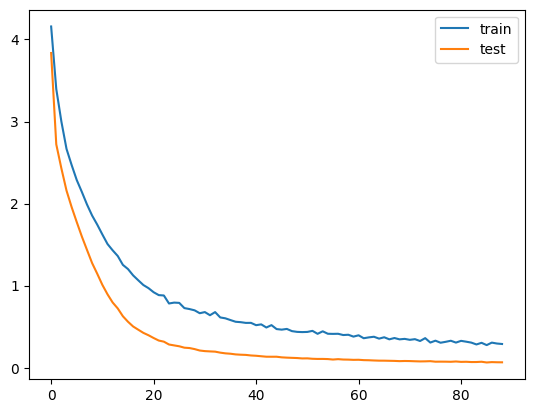


# TEST DATA #

27/27 [==============================] - 0s 727us/step - loss: 0.9528 - accuracy: 0.9296
accuracy: 92.96%

# Generate predictions
1/1 [==============================] - 0s 61ms/step
y=Speaker032- prediction=Speaker032- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker054- prediction=Speaker054- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker013- prediction=Speaker013- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker048- prediction=Speaker048- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker001- prediction=Speaker001- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker019- prediction=Speaker019- match=True
1/1 [==============================] - 0s 15ms/step
y=Speaker000- prediction=Speaker000- match=True
1/1 [==============================] - 0s 16ms/step
y=Speaker052- prediction=Speaker052- match=True
1/1 [==============================] - 0s 15ms/step
y=

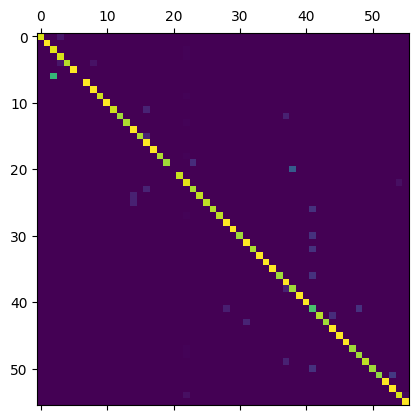


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00        24
           2       0.59      0.96      0.73        24
           3       0.89      0.94      0.91        17
           4       1.00      0.89      0.94        18
           5       1.00      1.00      1.00        15
           6       0.00      0.00      0.00        16
           7       1.00      1.00      1.00        13
           8       0.95      1.00      0.98        20
           9       1.00      0.92      0.96        13
          10       1.00      1.00      1.00        11
          11       1.00      0.92      0.96        13
          12       1.00      0.86      0.92         7
          13       1.00      0.88      0.93         8
          14       0.85      1.00      0.92        11
          15       1.00      0.88      0.93         8
          16       0.77      1.00      0.87        10
    

In [7]:
main("test", "train")

### Main 5 users all data

The features of the files in the folder audios/train_5_users will be saved to train.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|███████████████████████████████████████████| 25/25 [00:14<00:00,  1.68it/s]


End of extractWavFeatures
The features of the files in the folder audios/test_5_users will be saved to test.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|█████████████████████████████████████████| 481/481 [04:44<00:00,  1.69it/s]

End of extractWavFeatures
CSV files are created
train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.058543        2159.171943         1477.546297  3585.128321   
1  0.071461        1714.387915         1341.327063  2918.874017   
2  0.069618        1750.547787         1437.837080  3140.914341   
3  0.051973        1890.436168         1406.514930  3265.221922   
4  0.079688        1774.405770         1414.356557  3106.703298   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.150862 -276.257874   87.913521 -52.449951  28.438890   
1            0.105527 -281.259766  101.597984 -36.084454  28.539978   
2            0.108541 -259.571350  109.459450 -37.550751  47.283482   
3            0.129277 -315.539032   90.941017 -37.263245  47.555668   
4            0.112322 -265.787903  102.740761 -45.937241  28.389242   

       mfcc5  ...     mfcc12    mfcc13     mfcc14    mfcc15    mf

1/1 [==============================] - 0s 455ms/step - loss: 4.4845 - accuracy: 0.0000e+00 - val_loss: 4.5496 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 4.7217 - accuracy: 0.0588 - val_loss: 4.4955 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 4.2931 - accuracy: 0.0000e+00 - val_loss: 4.4365 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 4.3295 - accuracy: 0.0000e+00 - val_loss: 4.3724 - val_accuracy: 0.1250
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 4.3015 - accuracy: 0.0000e+00 - val_loss: 4.3072 - val_accuracy: 0.2500
Epoch 6/100
1/1 [==============================] - 0s 21ms/step - loss: 4.1255 - accuracy: 0.0588 - val_loss: 4.2445 - val_accuracy: 0.2500
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 4.0716 - accuracy: 0.0588 - val_loss: 4.1807 - val_accuracy: 0.2500
Epo

1/1 [==============================] - 0s 20ms/step - loss: 0.2021 - accuracy: 1.0000 - val_loss: 0.6271 - val_accuracy: 0.8750
Epoch 60/100
1/1 [==============================] - 0s 20ms/step - loss: 0.1540 - accuracy: 1.0000 - val_loss: 0.6256 - val_accuracy: 0.8750
Epoch 61/100
1/1 [==============================] - 0s 20ms/step - loss: 0.2003 - accuracy: 0.9412 - val_loss: 0.6237 - val_accuracy: 0.8750
Epoch 62/100
1/1 [==============================] - 0s 20ms/step - loss: 0.2940 - accuracy: 0.8824 - val_loss: 0.6212 - val_accuracy: 0.8750
Epoch 63/100
1/1 [==============================] - 0s 19ms/step - loss: 0.1865 - accuracy: 0.9412 - val_loss: 0.6182 - val_accuracy: 0.8750
Epoch 64/100
1/1 [==============================] - 0s 20ms/step - loss: 0.1928 - accuracy: 0.9412 - val_loss: 0.6158 - val_accuracy: 0.8750
Epoch 65/100
1/1 [==============================] - 0s 20ms/step - loss: 0.2304 - accuracy: 0.9412 - val_loss: 0.6136 - val_accuracy: 0.8750
Epoch 66/100
1/1 [========

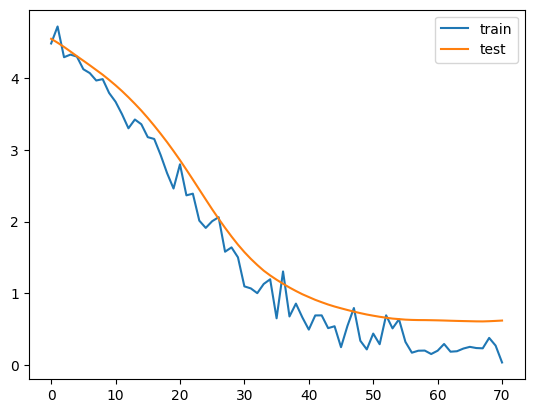


# TEST DATA #

16/16 [==============================] - 0s 882us/step - loss: 0.3343 - accuracy: 0.9293
accuracy: 92.93%

# Generate predictions
1/1 [==============================] - 0s 42ms/step
y=Speaker002- prediction=Speaker002- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker001- prediction=Speaker002- match=False
1/1 [==============================] - 0s 13ms/step
y=Speaker000- prediction=Speaker000- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker000- prediction=Speaker000- match=True
1/1 [==============================] - 0s 15ms/step
y=Speaker001- prediction=Speaker001- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker002- prediction=Speaker002- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker002- prediction=Speaker002- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker004- prediction=Speaker004- match=True
1/1 [==============================] - 0s 15ms/step
y

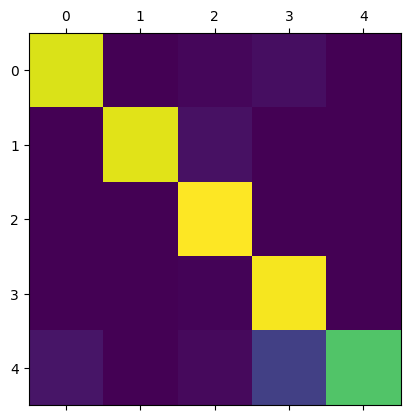


Classification Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        88
           1       1.00      0.96      0.98       113
           2       0.91      1.00      0.95       115
           3       0.81      0.99      0.89        80
           4       1.00      0.73      0.84        85

    accuracy                           0.93       481
   macro avg       0.93      0.92      0.92       481
weighted avg       0.94      0.93      0.93       481



In [8]:
main("test_5_users", "train_5_users")

### Main 5 users with 5 train registers

The features of the files in the folder audios/train_5_users_5_train will be saved to train.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|███████████████████████████████████████████| 25/25 [00:15<00:00,  1.67it/s]


End of extractWavFeatures
The features of the files in the folder audios/test_5_users_5_train will be saved to test.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|█████████████████████████████████████████| 481/481 [04:48<00:00,  1.67it/s]

End of extractWavFeatures
CSV files are created
train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.058543        2159.171943         1477.546297  3585.128321   
1  0.071461        1714.387915         1341.327063  2918.874017   
2  0.069618        1750.547787         1437.837080  3140.914341   
3  0.051973        1890.436168         1406.514930  3265.221922   
4  0.079688        1774.405770         1414.356557  3106.703298   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.150862 -276.257874   87.913521 -52.449951  28.438890   
1            0.105527 -281.259766  101.597984 -36.084454  28.539978   
2            0.108541 -259.571350  109.459450 -37.550751  47.283482   
3            0.129277 -315.539032   90.941017 -37.263245  47.555668   
4            0.112322 -265.787903  102.740761 -45.937241  28.389242   

       mfcc5  ...     mfcc12    mfcc13     mfcc14    mfcc15    mf

1/1 [==============================] - 0s 451ms/step - loss: 4.4370 - accuracy: 0.1765 - val_loss: 4.4678 - val_accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 4.4386 - accuracy: 0.0588 - val_loss: 4.4086 - val_accuracy: 0.2500
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 4.0977 - accuracy: 0.2941 - val_loss: 4.3443 - val_accuracy: 0.2500
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 4.3224 - accuracy: 0.1176 - val_loss: 4.2774 - val_accuracy: 0.2500
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 4.1959 - accuracy: 0.1176 - val_loss: 4.2074 - val_accuracy: 0.2500
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 4.1375 - accuracy: 0.1765 - val_loss: 4.1370 - val_accuracy: 0.6250
Epoch 7/100
1/1 [==============================] - 0s 20ms/step - loss: 4.2428 - accuracy: 0.0000e+00 - val_loss: 4.0654 - val_accuracy: 0.6250
Epoch 8/100
1/1 [==========

1/1 [==============================] - 0s 20ms/step - loss: 0.4167 - accuracy: 0.8235 - val_loss: 0.6138 - val_accuracy: 0.8750
Epoch 60/100
1/1 [==============================] - 0s 20ms/step - loss: 0.4870 - accuracy: 0.8235 - val_loss: 0.6195 - val_accuracy: 0.8750
Epoch 60: early stopping


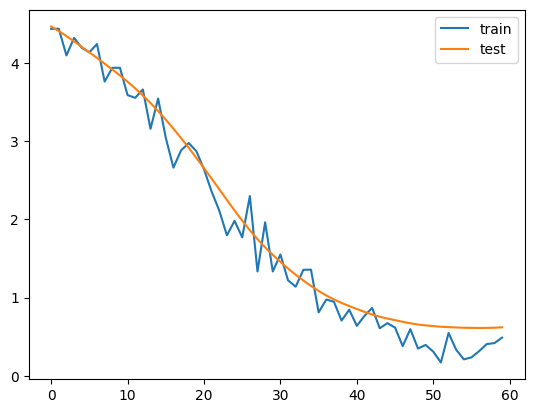


# TEST DATA #

16/16 [==============================] - 0s 869us/step - loss: 0.5093 - accuracy: 0.8711
accuracy: 87.11%

# Generate predictions
1/1 [==============================] - 0s 44ms/step
y=Speaker002- prediction=Speaker002- match=True
1/1 [==============================] - 0s 15ms/step
y=Speaker001- prediction=Speaker002- match=False
1/1 [==============================] - 0s 14ms/step
y=Speaker000- prediction=Speaker000- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker000- prediction=Speaker000- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker001- prediction=Speaker001- match=True
1/1 [==============================] - 0s 14ms/step
y=Speaker002- prediction=Speaker002- match=True
1/1 [==============================] - 0s 13ms/step
y=Speaker002- prediction=Speaker002- match=True
1/1 [==============================] - 0s 15ms/step
y=Speaker004- prediction=Speaker004- match=True
1/1 [==============================] - 0s 15ms/step
y

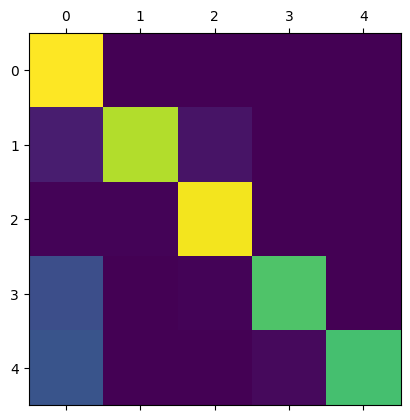


Classification Report
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        88
           1       0.99      0.88      0.93       113
           2       0.94      0.98      0.96       115
           3       0.97      0.72      0.83        80
           4       1.00      0.71      0.83        85

    accuracy                           0.87       481
   macro avg       0.91      0.86      0.86       481
weighted avg       0.91      0.87      0.87       481



In [9]:
main("test_5_users_5_train", "train_5_users_5_train")

### Save model

In [10]:
model.save('speaker-recognition.h5')

NameError: name 'model' is not defined


Transfer learning

https://keras.io/guides/transfer_learning/


### Load model

In [ ]:
new_model = keras.models.load_model('speaker-recognition.h5')
printPrediction(X_test[0:20], y_test[0:20], False, new_model)